# BIOEE 4940 : **Introduction to Quantitative Analysis in Ecology**
### ***Spring 2021***
### Instructor: **Xiangtao Xu** ( ✉️ xx286@cornell.edu)
### Teaching Assistant: **Yanqiu (Autumn) Zhou** (✉️ yz399@cornell.edu)

---

## <span style="color:royalblue">Lecture 8</span> *Regression IV: GLM and GAM*
*Partly adapted from [How to be a quantitative ecologist](https://www.researchgate.net/publication/310239832_How_to_be_a_Quantitative_Ecologist_The_'A_to_R'_of_Green_Mathematics_and_Statistics) and [All of Statistics](https://www.stat.cmu.edu/~larry/all-of-statistics/)*




#### 1. Generalized Linear Model (GLM)
* Motivation - Discrete Response Variables
  
  Consider the phenological dates observations we have extracted in HM1. What if we want to calculate the probability of budburst from day of year at a given station?
  
  

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df_pheno = pd.read_csv('./data/data_combined.csv')
# select one station and one species
df_bb = df_pheno.query('PEP_ID == 450 & sp == "QURO"')

In [ ]:
# since we know the budburst date, 
# we can create the status of budburst as a function of doy in each year

doys = np.arange(1,200+1) # consider day 1 to day 200
total_doys = []
bb_status = []
for i, day_bb in enumerate(df_bb['DAY_BB'].values):
    total_doys.extend(doys.tolist())
    bb_status.extend((doys >= day_bb).astype(int).tolist())

df_status = pd.DataFrame({'doy' : total_doys,'bb_status' : bb_status})


In [ ]:
fig, ax = plt.subplots(1,1)
df_status.plot.scatter(x='doy',y='bb_status',edgecolor='none',alpha=0.2,ax=ax)


# linear regression?
import statsmodels.api as sm
import statsmodels.formula.api as smf

res_ols = smf.ols('bb_status ~ doy',df_status).fit()
print(res_ols.summary())
pred_Y = res_ols.get_prediction({'doy' : doys}).summary_frame()

ax.plot(doys,pred_Y['mean'],'k-',lw=2)
ax.plot(doys,pred_Y[['mean_ci_lower','mean_ci_upper']],'r--',lw=1)
plt.show()

* Logistic Regression

Logistic regression is a parametric method for regression when Y is binary (0-1), which has a distribution of Bernoulli distribution.

Instead of using the raw binary variable as the response variable, logistic regression assumes (1) the independent variables determine the **probability** of the response variable, and (2) the probability increases **logistically** with indepdent variables.

A logistic function or logistic curve is a common S-shaped curve (sigmoid curve) with equation

$f(x)={\frac {L}{1+e^{-k(x-x_{0})}}}$ where

${\displaystyle x_{0}}$, the ${\displaystyle x}$ value of the sigmoid's midpoint;

${\displaystyle L}$, the curve's maximum value;

${\displaystyle k}$, the logistic growth rate or steepness of the curve

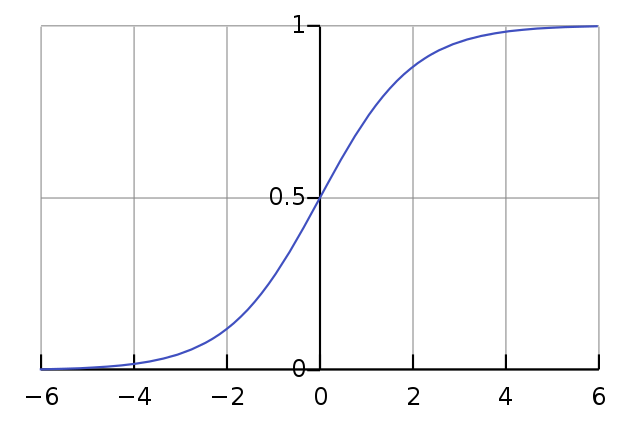

The equation of logistic regression can be thus written as

$p(Y) = \frac{1}{1 + e^{-(\beta_0 + \beta X)}} = \frac{e^{\beta_0 + \beta X}}{1 + e^{\beta_0 + \beta X}}$

We can convert this seemingly complex form into our familiar linear regression using the **logit** (logistic unit, the log-transform of the odds) transform.

$logit(p(Y)) = log(\frac{p(Y)}{1-p(Y)})$

--> $logit(p(Y)) = \beta_0 + \beta X$




* link function

More generally, we call the logit transform as a link function, which provides the linkage between the predictors (with a normal error term) and the mean of the response variables (could be in various distributions).

$g(Y) = \beta_0 + \beta X$, where g is the link function. 

common link functions for the family of exponential dispersion models (EDM)
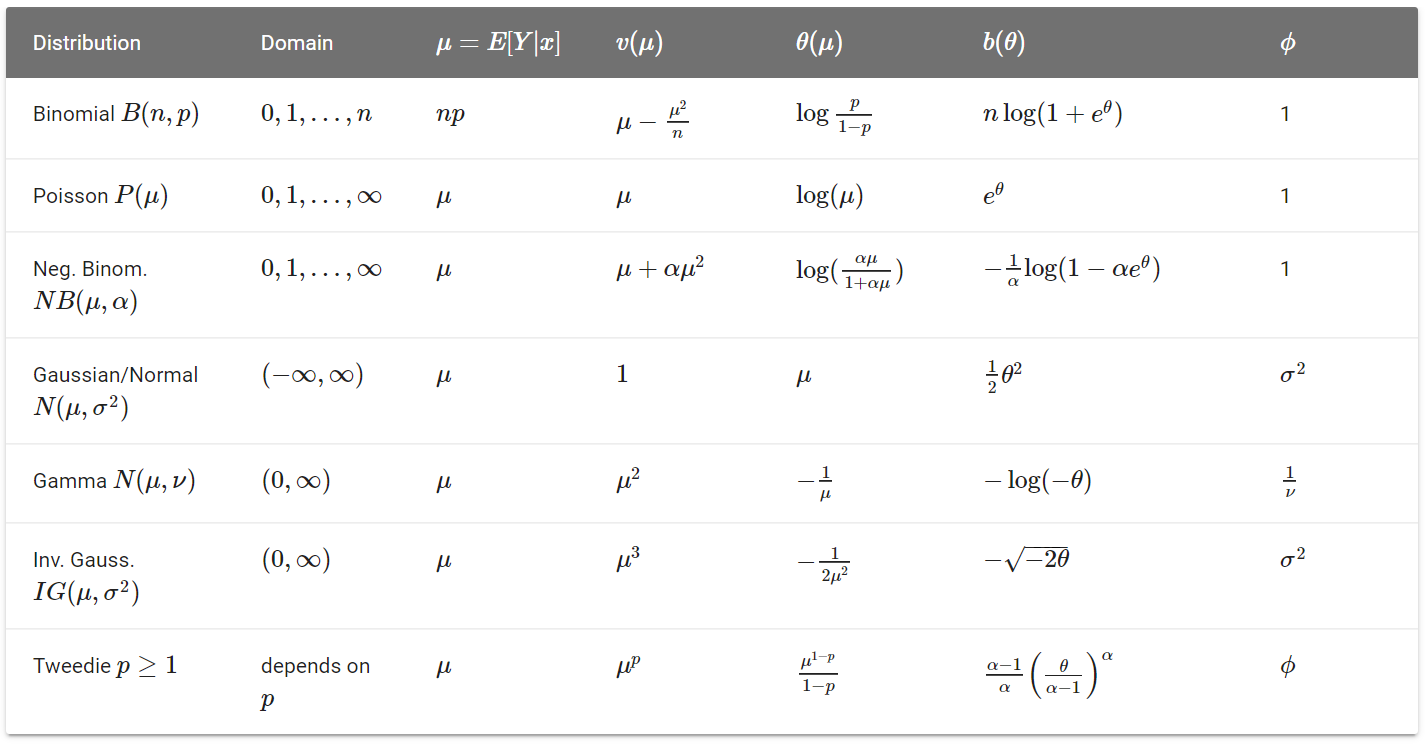

In [ ]:
# BB probability using glm
fig, ax = plt.subplots(1,1)
df_status.plot.scatter(x='doy',y='bb_status',edgecolor='none',alpha=0.2,ax=ax)


res_glm = smf.glm('bb_status ~ doy',df_status,family=sm.families.Binomial()).fit()
print(res_glm.summary())
pred_Y = res_glm.get_prediction({'doy' : doys}).summary_frame()

ax.plot(doys,pred_Y['mean'],'k-',lw=2)
ax.plot(doys,pred_Y[['mean_ci_lower','mean_ci_upper']],'r--',lw=1)

# compare with moving average probability
p_bb = np.zeros_like(doys,dtype=float)
mw = 3
for i, doy in enumerate(doys):
    df_sub = df_status.query(f'(doy >= {doy - mw}) & (doy <= {doy + mw})')
    p_bb[i] = sum(df_sub['bb_status'] == 1) / df_sub.shape[0]
    
ax.plot(doys,p_bb,'b--',lw=1)
    
plt.show()

* GLM Ecological Example I: Regression over count data


In [ ]:
# first read data

df_bci = pd.read_excel('../Lecture2/data/bci_census.xlsx')
# a 200 m by 500 m quadrat of the whole census (10 Ha)
# subset to 100m by 100m and only include alive trees
df_plot = df_bci.query('(gx < 200) & (gy < 100) & DFstatus == "alive"')

In [ ]:
from matplotlib import cm

# visualize
fig,ax = plt.subplots(1,1)
sp_list = df_plot['sp'].value_counts().index[0:10]
plot_c = cm.get_cmap('tab10')(range(len(sp_list)))
# loop over sp_list
for isp, sp in enumerate(sp_list):
    df_sub = df_plot[df_plot['sp'] == sp]
    
    df_sub.plot.scatter(x='gx',y='gy',s=df_sub['dbh'],c=np.reshape(plot_c[isp,:],(1,-1)),
                        edgecolor='none',label=sp,alpha=0.5,ax=ax)
ax.grid(True)
ax.legend()
plt.show()


In [ ]:
# get every 5by5 quadrat
llxy = [(gx,gy) for gx in range(0,200,5) for gy in range(0,100,5)]

In [ ]:
# calculate some metrics for each quadrat
dbh_threshold = 100
N_small = []
BA_big = []
BA_total = []
DBH_max= []
for gx, gy in llxy:
    df_sub = df_plot.query(
        ' & '.join ([
            '(gx >= @gx)',
            '(gx <= @gx + 5)',
            '(gy <= @gy + 5)',
            '(gy >= @gy)']))
    N_small.append(sum(df_sub['dbh'] < dbh_threshold))
    BA_big.append(sum((df_sub[df_sub['dbh'] >= dbh_threshold]['dbh'] / 1000.) ** 2) * np.pi / 4.)
    BA_total.append(sum((df_sub['dbh'] / 1000.) ** 2) * np.pi / 4.)
    DBH_max.append(df_sub['dbh'].max())
    

In [ ]:

BA_big = np.array(BA_big)
N_small = np.array(N_small)
DBH_max = np.array(DBH_max)


df_counts = pd.DataFrame({'BA_big' : BA_big[BA_big > 0],'N_small' : N_small[BA_big > 0],
                           'DBH_max' : DBH_max[BA_big > 0]})
fig, axes = plt.subplots(1,2)
df_counts.plot.scatter(x='BA_big',y='N_small',ax=axes[0])
df_counts.plot.scatter(x='DBH_max',y='N_small',ax=axes[1])



In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

res_glm = smf.glm('N_small ~ BA_big + DBH_max',data=df_counts,family=sm.families.Poisson()).fit()

#ols regression
res_ols = smf.glm('N_small ~ BA_big + DBH_max',data=df_counts).fit()

In [ ]:
print(res_ols.summary())
print(res_glm.summary())

In [ ]:
pred_Y = glm_res.get_prediction().summary_frame()

fig, axes = plt.subplots(1,2)
ax = axes[0]
df_counts.plot.scatter(x='BA_big',y='N_small',edgecolor='none',alpha=0.2,ax=ax)

sort_idx = np.argsort(df_counts['BA_big'])
ax.plot(df_counts['BA_big'][sort_idx],pred_Y['mean'][sort_idx],'k-',lw=2)
ax.plot(df_counts['BA_big'][sort_idx],pred_Y.iloc[sort_idx][['mean_ci_lower','mean_ci_upper']],'r--',lw=1)

ax = axes[1]
df_counts.plot.scatter(x='DBH_max',y='N_small',edgecolor='none',alpha=0.2,ax=ax)

sort_idx = np.argsort(df_counts['DBH_max'])
ax.plot(df_counts['DBH_max'][sort_idx],pred_Y['mean'][sort_idx],'k-',lw=2)
ax.plot(df_counts['DBH_max'][sort_idx],pred_Y.iloc[sort_idx][['mean_ci_lower','mean_ci_upper']],'r--',lw=1)

fig.tight_layout()
plt.show()

* GLM Ecological Example II: Survival analysis


In [ ]:
# read census data from Costa Rica
df_cr = pd.read_csv('./data/CR_drought_data.csv')
df_cr
# Question, what determines the survival (2013-2015) of plants?

In [ ]:
pd.plotting.scatter_matrix(df_cr[['RGR','survived','WD','SLA','DBH']])
plt.show()

In [ ]:
# fit a GLM
reg_glm = smf.glm('survived ~ RGR + WD + SLA + DBH',family=sm.families.Binomial(),data=df_cr).fit()
print(reg_glm.summary())

In [ ]:
reg_glm2 = smf.glm('survived ~ RGR * DBH + WD',family=sm.families.Binomial(),data=df_cr).fit()
print(reg_glm2.summary())

In [ ]:
reg_glm3 = smf.glm('survived ~ RGR + RGR : DBH + WD',family=sm.families.Binomial(),data=df_cr).fit()
print(reg_glm3.summary())

In [ ]:
print(reg_glm.aic,reg_glm2.aic,reg_glm3.aic)

In [ ]:
x_vars = ['RGR','WD','DBH']
fig, axes = plt.subplots(1,len(x_vars))
for i, ax in enumerate(axes):
    x_var = x_vars[i]
    
    df_pred = {x_var: np.linspace(df_cr[x_var].min(),df_cr[x_var].max(),100)}
    for j in x_vars:
        if j != x_var:
            df_pred[j] = np.ones_like(df_pred[x_var]) * df_cr[j].mean()
    
    pred_Y = reg_glm3.get_prediction(df_pred).summary_frame()

    
    df_cr.plot.scatter(x=x_var,y='survived',edgecolor='none',alpha=0.2,ax=ax)

    ax.plot(df_pred[x_var],pred_Y['mean'],'k-',lw=2)
    ax.plot(df_pred[x_var],pred_Y[['mean_ci_lower','mean_ci_upper']],'r--',lw=1)

fig.tight_layout()
plt.show()

* Generalized Linear Mixed Models (GLMM)

In [ ]:
random = {"SP": '0 + C(sp)'}
mod_glmm = sm.BinomialBayesMixedGLM.from_formula(
           'survived ~ RGR + RGR : DBH + WD', random, df_cr)

In [ ]:
res_glmm = mod_glmm.fit_vb()
print(res_glmm.summary())

In [ ]:
print(res_glmm.fe_mean)

In [ ]:
res_gee = sm.GEE.from_formula('survived ~ RGR + RGR : DBH + WD', groups='sp',cov_struct=sm.cov_struct.Exchangeable(), data=df_cr).fit()

In [ ]:
print(res_gee.summary())

#### 2. General Additive Model (GAM)

* Motivation: fit non-linear relationship

In [ ]:
# get some nonlinear data....
df_evi = pd.read_csv('./data/arnot_forest_evi.csv')
df_evi['date'] = pd.to_datetime(df_evi['date'])
df_evi = df_evi.set_index('date')

df_evi

In [ ]:
df_evi.plot(y='EVI')

In [ ]:
df_evi['doy'] = df_evi.index.dayofyear

In [ ]:
df_evi.plot.scatter(x='doy',y='EVI')
# Question, how to come up with a smooth function to model seasonal cycle in EVI?

* Local regression

One idea is to use a moving window to fit local polynomial regressions to capture the nonlinear relationship.

One approach is called LOWESS (locally weighted scatterplot smoothing)

In [ ]:
lowess = sm.nonparametric.lowess
l1 = lowess(df_evi['EVI'], df_evi['doy'])
l2 = lowess(df_evi['EVI'], df_evi['doy'], frac=1./3)

fig, ax = plt.subplots(1,1)
df_evi.plot.scatter(x='doy',y='EVI',ax=ax)
ax.plot(l1[:,0],l1[:,1],'r--')
ax.plot(l2[:,0],l2[:,1],'b--')


In [ ]:
# calculate decimal year
year = df_evi.index.year
doy = df_evi.index.dayofyear
is_leap = df_evi.index.is_leap_year
total_doy = np.ones_like(doy) * 365
total_doy[is_leap] = 366
dec_year = year + (doy-1) / total_doy

df_evi['dec_year'] = dec_year

l1 = lowess(df_evi['EVI'], df_evi['dec_year'])
l2 = lowess(df_evi['EVI'], df_evi['dec_year'], frac=1./30)

fig, ax = plt.subplots(1,1)
df_evi.plot.scatter(x='dec_year',y='EVI',ax=ax)
ax.plot(l1[:,0],l1[:,1],'r--')
ax.plot(l2[:,0],l2[:,1],'b--')

* Generalized Additive Models

The structure of GAM can be described as $g(E(Y))=\beta_0+s_1(X_1)+⋯+s_p(X_p)$, where g is the link function as in GLM; $s_i$ denote smooth, nonparametric functions, which was generated in a similar way as lowess.

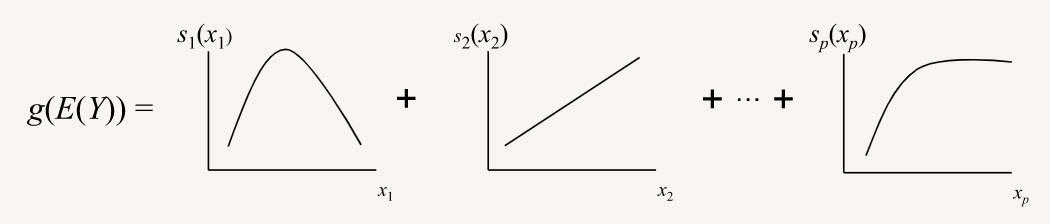

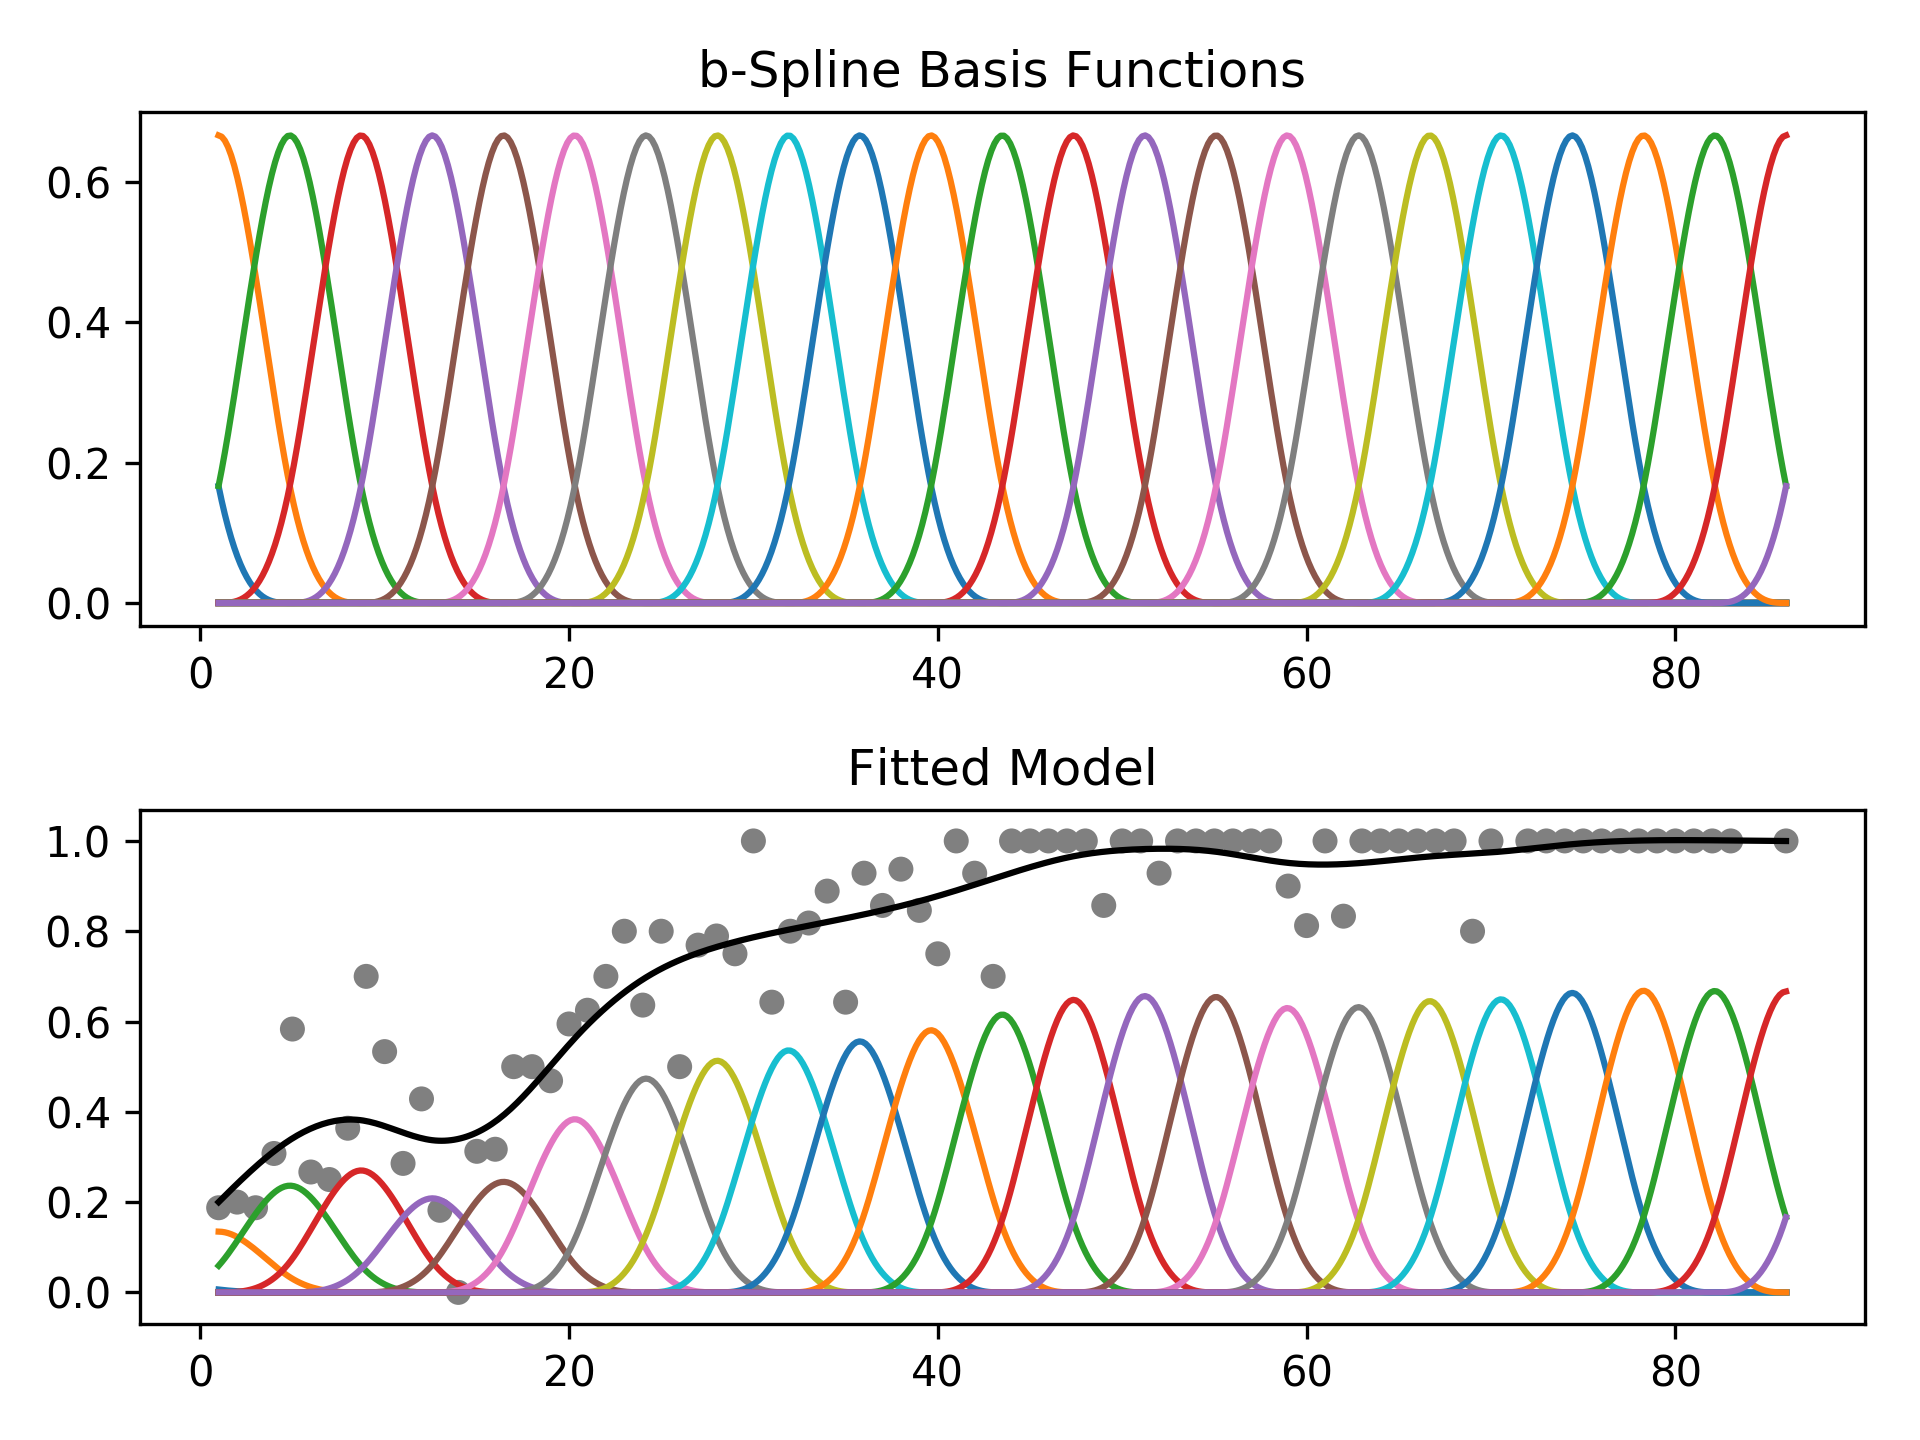

read [here](https://multithreaded.stitchfix.com/blog/2015/07/30/gam/) for extended information

In [ ]:
# use a package pygam
from pygam import LinearGAM,s

# model
gam_doy = LinearGAM(n_splines=10,lam=0.6).fit(df_evi['doy'],df_evi['EVI'])
print(gam_doy.summary())

# play with n_splings and lambda

In [ ]:
XX = np.arange(1,365)
plt.plot(XX,gam_doy.predict(XX))
plt.plot(XX,gam_doy.prediction_intervals(XX, width=0.95, quantiles=None),'r--')
plt.scatter(df_evi['doy'],df_evi['EVI'])


In [ ]:
# model
gam_year = LinearGAM(n_splines=100,lam=0.5).fit(df_evi['dec_year'],df_evi['EVI'])
print(gam_year.summary())

XX = np.arange(2001,2021,0.01)
plt.plot(XX,gam_year.predict(XX))
plt.plot(XX,gam_year.prediction_intervals(XX, width=0.95, quantiles=None),'r--')
plt.scatter(df_evi['dec_year'],df_evi['EVI'])

# how about extrapolation?

In [ ]:
# GAM for survival
from pygam import LogisticGAM, s,f
# model
gam_survival = LogisticGAM(s(0)+s(1)+s(2),n_splines=10,lam=0.6).fit(df_cr[['RGR','DBH','WD']],df_cr['survived'])

print(gam_survival.summary())

## plotting
plt.figure();
fig, axs = plt.subplots(1,3);

titles = ['RGR', 'DBH', 'WD']
for i, ax in enumerate(axs):
    XX = gam_survival.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam_survival.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam_survival.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    #if i == 0:
        #ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

#### 3. Summary of Regression Analysis


* OLS
* RLS (e.g. Type II regression, Theil-Sen Slope)
* Quantile Regression
* LMM
* GLM
* GAM
* Model Selection




In [ ]:
# Appendix
# data preparation for EVI
import ee

try:
    ee.Initialize()
except:
    # need to authenticate with your credential at the first time
    ee.Authenticate()
    ee.Initialize()
    
import geemap.eefolium as geemap


# timeseries of NDVI at Arnot Forest
af_loc = [42.271, -76.628] # a point within Arnot Forest

# identify a 100 meter buffer around our Point Of Interest (POI)
poi = ee.Geometry.Point(af_loc[1],af_loc[0]).buffer(100)

# save time-series
collection = (
    ee.ImageCollection('MODIS/006/MOD13Q1')   # name of image collection
      .filterDate('2001-01-01', '2021-01-01') # filter by time
      .filterBounds(poi)                      # filter by location
            )

def poi_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=poi, scale=250).get('EVI')
    return img.set('date', img.date().format()).set('mean',mean)

poi_reduced_imgs = collection.map(poi_mean)

nested_list = poi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

import pandas as pd
df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])
df['EVI'] = df['mean'] / 10000.
del df['mean']
df['date'] = pd.to_datetime(df['date'])
df.to_csv('./data/arnot_forest_evi.csv',index=False)